## IMDB Movie reviews - sentiment analysis <br>Notebook.
    
Text Mining and Social Media Mining <br> final project<br>
Bartłomiej Kuźma (384866) & Maciej Odziemczyk (388581)<br>
Faculty of Economic Sciences, University of Warsaw <br>
February 2021 

Sentiment analysis of IMDB movie reviews was made in this project. 
Some text preprocessing and exploratory data analysis was performed. 
Then the main model was trained (CNN).
CNN was built based on the pretrained GloVe embeddings.
CNN results were compared to simple VADER approach.
At the end, some experiments were made to check to what point this model is sensible to embeddings dimensionality, reviews' maximum length limitations and stopwords usage during training. Recurrent Neural Network was trained too, but the results were not good enough.

#### Table of contents
- *Data preparation and analysis*
    - data loading,
    - checking for nulls,
    - balance check,
    - entry level clearing,
    - label encoding,
    - train/dev/test split,
    - embedding upload,
    - coverage check,
    - detailed clearing,
    - length choice,
    - visualizations (stop words analysiss included),
        - bar plots with most frequent words for both categories,
        - word cloud for both categories.
        
- *Modelling*
    - tokenization,
    - embeddings assignment,
    - Convolutional Neural Network,
        - training,
        - evaluation metrics,
        - accuracy and loss plots,
        - confusion matrix analysis,
        - examples of misclassification,
    - Vader analysis,
        - computating scores,
        - confusion matrix analysis,
        - evaluation metrics.
        
- *Expermiments*
     - Convolutional Neural Networks,
         - max length of 250 words, 100D embedding,
         - max length of 500 words, 100D embedding,
         - max length of 1000 words, 100D embedding,
         - max length of 500 words, 50D embedding,
         - max length of 500 words, 300D embedding,
         - max length of 500 words, 100D embedding (without stopwords),
     - Recurrent Neural Network,
         - max length of 500 words, 100D embedding.

In [1]:
# libraries
#    basics
import pandas as pd                                  # data manipulation
import numpy as np                                   # linear algebra
import matplotlib.pyplot as plt                      # plots
import seaborn as sns                                # nicer plots :)
import time                                          # timing
import os                                            # external files loading
import gc                                            # memory cleaning
import operator                                      # some operators
import re                                            # regular expressions 
from wordcloud import WordCloud,STOPWORDS            # word cloud plots and stopwords list
from sklearn.model_selection import train_test_split # train test split
from sklearn.metrics import classification_report    # sklearn metrics
from sklearn.metrics import confusion_matrix         # confusion matrix
import own                                           # own functions (for experiments)

#    Deep Learning
import tensorflow as tf                              # tensorflow background
from tensorflow import keras                         # keras API

from keras.layers import Input, Conv1D, Bidirectional, LSTM, Dropout, Dense, Flatten, MaxPooling1D, Input, Embedding
from keras.models import Model                       # model building

In [2]:
# random seed configuration
tf.random.set_seed(seed = 2021)
np.random.seed(seed = 2021)

In [3]:
# dataset loading
data = pd.read_csv("IMDB Dataset.csv")

In [4]:
# missings
data.isnull().sum()

review       0
sentiment    0
dtype: int64

Dataset doesn't have nulls

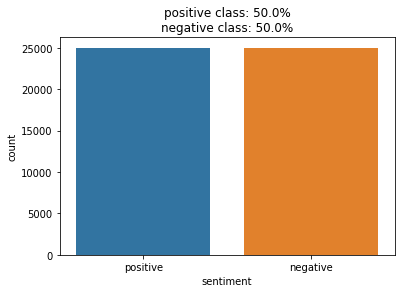

In [5]:
# balance check
sns.countplot(data['sentiment'])
positive_percent = round(np.sum(data.sentiment=="positive")/data.shape[0], 2)*100
plt.title("positive class: {}%\nnegative class: {}%".format(positive_percent, 100-positive_percent))
plt.show()

Well-balanced dataset, well the accuracy is correct metric in further analysis

In [6]:
# look into examples to get an intuition about reviews, cleaning etc.
ind = [2**k for k in range(15)]
for i in ind:
    print('\n{}. SENTIMENT:\t{}'.format(i,data.sentiment[i]))
    print(data.review[i])


1. SENTIMENT:	positive
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) a

HTML tags has to be removed ("<...>"), transforming "&" to "and" should be ok. Numbers in range 0-10 should stay, it can be a rate, so NN could find it useful (this number may be element of the movei title too). Words in "" heve often negative meaning, so its make a lot of noise, titles etc. are in "" also, should be deleted.

In [7]:
# entry level data clearing
# strategy is to substitute with space then remove unnecessary spaces

# remove HTML tags
data.review = data.review.apply(lambda x: re.sub("<.*?>", " ", x))
# substitute "&" with "and"
data.review = data.review.apply(lambda x: re.sub("[&]", "and", x))
#remove punctuation, and non alphanumeric characters excluding apostrophe
data.review = data.review.apply(lambda x: re.sub("[^a-zA-Z0-9 ']", " ", x))
# remove numbers >10
data.review = data.review.apply(lambda x: re.sub("([2-9][0-9]|1[1-9]|\d{3,})", " ", x))
# delete unnecessary spaces
data.review = data.review.apply(lambda x: re.sub(" +", " ", x))
# transform to lowercase
data.review = data.review.apply(lambda x: x.lower())

In [8]:
# look into examples after entry cleaning
ind = [2**k for k in range(15)]
for i in ind:
    print('\n{}. SENTIMENT:\t{}'.format(i,data.sentiment[i]))
    print(data.review[i])


1. SENTIMENT:	positive
a wonderful little production the filming technique is very unassuming very old time bbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams' diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great master's of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional 'dream' techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwell's murals decorating every surface are terribly well done 

2. SENTIMENT:	positive
i thoug

The reviews looks much better now, nevertheless after embedding coverage checking some more detailed cleaning should be performed.

In [9]:
# look into dataset structure
data

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,petter mattei's love in the time of money is a...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative


Look that the entry level clearing is done, now it is time to encode positive reviews as 1 and negative as 0.

In [10]:
# label encoding
data.sentiment = data.sentiment.apply(lambda x: 1 if x == "positive" else 0)

##### Dataset splitting - train, dev, test sets

Data were splitted into 3 sets (by hand). Train set is for model training, dev set is for training monitoring, and test set is for checking model results and compare it with VADER.

In [11]:
# shuffling
data = data.sample(frac = 1, random_state = 2021)

In [12]:
# proportions
train_size = 0.7
dev_size = 0.2
test_size = 0.1

# extracting training featuers and labels
train = data.iloc[range(int(data.shape[0]*train_size)), :].copy()
X_train = train.review.values
Y_train = train.sentiment.values

# extracting dev featuers and labels
dev = data.iloc[range(train.shape[0], train.shape[0]+int(data.shape[0]*dev_size)), :].copy()
X_dev = dev.review.values
Y_dev = dev.sentiment.values

# extracting test featuers and labels
test = data.iloc[range(train.shape[0]+dev.shape[0], data.shape[0]), :].copy()
X_test = test.review.values
Y_test = test.sentiment.values

In [13]:
# double check
tr_ind = train.index.tolist()
tr_ind.extend(dev.index.tolist())
tr_ind.extend(test.index.tolist())

print("split is ok:", data.index.tolist()==tr_ind)

split is ok: True


##### Loading embedding vocabulary and adding an unknown token

A this stage the pretrained embeddings have to be implemented. In the main analysis GloVe 100 dimensional matrix was used. Model's sensitivity to GloVe embedding dimension analysis was performed at the end.

In [15]:
# dictionary inicialization
embeddings_index = {}

# file opening with utf8 encoding (some characters may cause an error)
f = open("glove.6B.100d.txt", encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


In [16]:
# look for different-shaped embeddings (in the case of glove 300 some lower-dimension examples were found)

# inicialize dict (key: word, value: embedding shape)
words = {}
# position, to check if there is a pattern
iis = []

# loop
for i, word in enumerate(embeddings_index.keys()):
    # current word embedding shape
    shape = embeddings_index[word].shape[0]
    # condtition check (100 because current glove has 100 dimension vectors)
    if shape != 100:
        # saving
        words[word] = shape
        iis.append(i)

In [17]:
# check
words

{}

All the embedding has the same dimension, that is good <br>
If the word from dataset can't be found, a special, unknown token OOV has been assigned to it. OOV token is an average of all the other tokens.


In [18]:
# unknown token computation
start = time.time()
unknown = sum(embeddings_index.values())/len(embeddings_index)
stop = time.time()
print("Execution time: {} seconds".format(round(stop-start, 2)))

Execution time: 0.2 seconds


In [19]:
# saving computed unknown to embedding
embeddings_index["<OOV>"] = unknown

##### Vocabulary analysis (embedding coverage, more advanced cleaning, EDA)

In [20]:
def get_vocabulary(data, return_dataframe = False):
    '''
    function creates vocabulary for given series of sentences
    data - pd.Series with with text data
    return_dataframe - return sorted pandas DataFrame if True 
    
    return vocabulary (dictionary, keys: words, values: counts or dataframe sorted by occurrence)
    '''
    # dictionary inicialization
    vocabulary = {}
        
    # sentence level loop
    for sentence in data:
        words = sentence.split()
        # word level loop
        for word in words:
            if word not in vocabulary.keys():
                vocabulary[word] = 1
            else:
                vocabulary[word] += 1
                
    # sorting
    if return_dataframe:
        vocabulary = pd.DataFrame(vocabulary.items(), columns = ["word", "count"]).sort_values("count", ascending = False)
            
    return vocabulary

In [21]:
def coverage(data, embedding, info = False):
    '''
    function to check coverage with given embedding
    data - pd.Series with text data
    embedding - word embedding dictionary
    info - coverage percentage printed if true - two measures (occurrence weighting and raw)
    
    return covered, non_covered (dicts key: word, value: count) 
    '''
    
    # get vocabulary
    vocabulary = get_vocabulary(data)
    
    # inicialization
    covered = {}
    non_covered = {}
    
    # loop through vocabulary
    for word in vocabulary.keys():
        if word in embedding.keys():
            covered[word] = vocabulary[word]
        else:
            non_covered[word] = vocabulary[word]
    
    # DataFrame conversion
    covered = pd.DataFrame(covered.items(), columns = ["word", "count"]).sort_values("count", ascending = False)
    non_covered = pd.DataFrame(non_covered.items(), columns = ["word", "count"]).sort_values("count", ascending = False)
    
    if info:
        print("Covered words percentage: {}% raw: {}%".format(round(
            100 * covered["count"].sum()/(covered["count"].sum()+non_covered["count"].sum()),
            4), round(100 * covered.shape[0]/(covered.shape[0]+non_covered.shape[0]), 4)))
        print("Non-covered words percentage: {}% raw: {}%".format(round(
            100 * non_covered["count"].sum()/(covered["count"].sum()+non_covered["count"].sum()), 
            4), round(100 * non_covered.shape[0]/(covered.shape[0]+non_covered.shape[0]), 4)))
    
    
    return covered, non_covered

GloVe coverage analysis

In [22]:
cov, non_cov = coverage(X_train, embeddings_index, info = True)

Covered words percentage: 97.4941% raw: 65.254%
Non-covered words percentage: 2.5059% raw: 34.746%


As it can be see GloVe covers 97.49% of the whole vocabulary (weighted by occurance) used in those reviews and 65.25% of the unique words. Improvement attempt was made below.

To perform more specyfic data cleaning, most frequent uncovered words were analyzed to check whether there were some contractions like it's etc. The analysis was performed on the train set

In [22]:
non_cov.iloc[:30,:]

,word,count
11,it's,23457
32,don't,11880
23,i'm,6537
13,doesn't,6198
7,didn't,6115
107,can't,4904
4,that's,4713
8,i've,4656
40,isn't,4314
3,there's,4274


In [23]:
non_cov.iloc[30:60,:]

,word,count
232,weren't,665
264,movie's,548
209,you'd,538
162,hasn't,485
165,man's,471
448,shouldn't,471
208,character's,411
255,director's,392
324,today's,380
183,here's,368


In [24]:
non_cov.iloc[60:90,:]

,word,count
404,show's,150
592,mother's,146
321,hitchcock's,143
104,someone's,142
331,guy's,138
1040,characters',128
1092,god's,126
997,america's,126
259,hollywood's,125
613,year's,124


In [25]:
non_cov.iloc[90:120,:]

,word,count
737,devil's,90
86,actors',86
915,son's,85
1755,ford's,84
149,she'd,83
45,killer's,83
285,daughter's,82
2051,she'll,81
836,chaplin's,80
4182,brother's,80


In [26]:
non_cov.iloc[120:150,:]

,word,count
4775,wood's,59
3052,tv's,59
108,heaven's,58
158,who've,57
636,keaton's,57
198,it'd,57
2050,must've,56
612,john's,56
1371,imho,56
212,sister's,55


In [27]:
non_cov.iloc[150:180,:]

,word,count
39,michael's,47
436,victim's,47
1956,dad's,47
518,who'd,47
2213,allen's,47
2228,town's,46
4556,jane's,46
2810,miyazaki's,46
3383,howard's,45
211,everybody's,44


In [28]:
non_cov.iloc[180:210,:]

,word,count
3929,brown's,40
1282,'what,40
4021,tony's,40
467,murphy's,40
4120,joe's,39
1233,craven's,39
3576,boys',39
4282,taylor's,39
434,series',39
3232,anderson's,38


The function below is based on above tables analysis. Regex cleaning.

In [23]:
def clean(x):
    '''
    cleaning function to combine with series.apply(lambda x: clean(x))
    '''
    
    x = re.sub("it's", 'it is', x)
    x = re.sub("don't", 'do not', x)
    x = re.sub("i'm", 'i am', x)
    x = re.sub("doesn't", 'does not', x)
    x = re.sub("didn't", 'did not', x)
    x = re.sub("can't", 'can not', x)
    x = re.sub("that's", 'that is', x)
    x = re.sub("i've", 'i have', x)
    x = re.sub("isn't", 'is not', x)
    x = re.sub("there's", 'there is', x)
    x = re.sub("he's", 'he is', x)
    x = re.sub("wasn't", 'was not', x)
    x = re.sub("you're", 'you are', x)
    x = re.sub("couldn't", 'could not', x)
    x = re.sub("you'll", 'you will', x)
    x = re.sub("she's", 'she is', x)
    x = re.sub("i'd", 'i would', x) # assumption that i'd means i wolud, not i had (simplification)
    x = re.sub("they're", 'they are', x)
    x = re.sub("won't", 'will not', x)
    x = re.sub("wouldn't", 'would not', x)
    x = re.sub("i'll", 'i will', x)
    x = re.sub("aren't", 'are not', x)
    x = re.sub("haven't", 'have not', x)
    x = re.sub("what's", 'what is', x)
    x = re.sub("you've", 'you have', x)
    x = re.sub("who's", 'who is', x)
    x = re.sub("let's", 'let us', x)
    x = re.sub("'the", 'the', x)
    x = re.sub("we're", 'we are', x)
    x = re.sub("weren't", 'were not', x)
    x = re.sub("you'd", 'you would', x) # assumption that you'd means you wolud, not you had (simplification)
    x = re.sub("hasn't", 'has not', x)
    x = re.sub("shouldn't", 'should not', x)
    x = re.sub("here's", 'here is', x)
    x = re.sub("hadn't", 'had not', x)
    x = re.sub("we've", 'we have', x)
    x = re.sub("they've", 'whey have', x)
    x = re.sub("ain't", 'not', x) # simplification
    x = re.sub("would've", 'would have', x)
    x = re.sub("could've", 'could have', x)
    x = re.sub("he'd", 'he would', x) # assumption that he'd means he wolud, not he had (simplification)
    x = re.sub("we'll", 'we will', x)
    x = re.sub("they'd", 'they would', x) # assumption that they'd means they wolud, not they had (simplification)
    x = re.sub("it'll", 'it will', x)
    x = re.sub("they'll", 'they will', x)
    x = re.sub("he'll", 'he will', x) 
    x = re.sub("we'd", 'we would', x) # assumption that we'd means we wolud, not we had (simplification)
    x = re.sub("should've", 'should have', x)
    x = re.sub("she'd", 'she would', x) # assumption that she'd means she wolud, not she had (simplification)
    x = re.sub("she'll", 'she will', x)
    x = re.sub("'i", 'i', x) 
    x = re.sub("who've", 'who have', x)
    x = re.sub("it'd", 'it would', x) # assumption that she'd means she wolud, not she had (simplification)
    x = re.sub("bandw", 'b and w', x) 
    x = re.sub("that'll", 'that will', x) 
    x = re.sub("imho", 'in my humble opinion', x)
    x = re.sub("who'd", 'who would', x) # assumption that who'd means who wolud, not who had (simplification)
    x = re.sub("o'", 'o', x)
    x = re.sub("must've", 'must have', x)
    x = re.sub("'what", 'what', x)
    x = re.sub("it'", 'it', x)
    x = re.sub("its'", 'its', x)
    
    return x 

In [24]:
# advanced cleaning
X_train = pd.Series(X_train).apply(lambda x: clean(x)).values

In [25]:
# coverage after final cleaning
cov, non_cov = coverage(X_train, embeddings_index, info = True)

Covered words percentage: 98.9452% raw: 65.5583%
Non-covered words percentage: 1.0548% raw: 34.4417%


As it can be seen coverage is now better by approximately 1.5 percentage points on the whole vocabulary and by approximately 0.4 percentage points on the unique vocabulary 

Based on training set coverage analysis, dev and test set were cleaned below.

In [26]:
X_dev = pd.Series(X_dev).apply(lambda x: clean(x)).values
X_test = pd.Series(X_test).apply(lambda x: clean(x)).values

Reviews has no length limit, using all the examples with potential outliers (in the length sense - there are even 2500 words long records) could cause some computational issues, removing some too long reviews seem to be reasonable. The analysis below is about dataset size with length bounded reviews.

In [27]:
# creating temporary dataframe (train, dev, test stplitting was preformed before)
temp_df = pd.DataFrame(np.r_[X_train,X_dev,X_test], columns=["review"])
# creating column with review length information
temp_df["length"] = temp_df.review.apply(lambda x: len(x.split()))

# analysis
print("Shape of data with all the observations\t\t", data.shape)
print("Shape of data with reviews shorter than 1000 words", temp_df.where(temp_df.length <= 1000).dropna().shape)
print("Shape of data with reviews shorter than 500 words", temp_df.where(temp_df.length <= 500).dropna().shape)
print("Shape of data with reviews shorter than 400 words", temp_df.where(temp_df.length <= 400).dropna().shape)
print("Shape of data with reviews shorter than 350 words", temp_df.where(temp_df.length <= 350).dropna().shape)
print("Shape of data with reviews shorter than 250 words", temp_df.where(temp_df.length <= 250).dropna().shape)


Shape of data with all the observations		 (50000, 2)
Shape of data with reviews shorter than 1000 words (49832, 2)
Shape of data with reviews shorter than 500 words (46016, 2)
Shape of data with reviews shorter than 400 words (43375, 2)
Shape of data with reviews shorter than 350 words (41348, 2)
Shape of data with reviews shorter than 250 words (34957, 2)


Only 168 observations were lost when 1000 bound was established. It seems to be reasonable constraint.

Below the application of the limiation to the data set is being made.

In [28]:
# removing too long reviews
selected_max_length = 1000
temp_df = temp_df.where(temp_df.length <= selected_max_length).dropna().reset_index(drop = True)
print("data shape:", temp_df.shape)
maxLen = selected_max_length

data shape: (49832, 2)


In [29]:
# train, dev, test split again (on cutted dataset)

temp_train = pd.DataFrame(np.c_[X_train,Y_train], columns = ["review", "sentiment"])
temp_train["length"] = temp_train.review.apply(lambda x: len(x.split()))
temp_train = temp_train.where(temp_train.length <= selected_max_length).dropna().reset_index(drop = True) 
X_train = temp_train.review.values
Y_train = temp_train.sentiment.values.astype(int) # labels has to be casted to int (numpy arrays has uniform datatype)

temp_dev = pd.DataFrame(np.c_[X_dev,Y_dev], columns = ["review", "sentiment"])
temp_dev["length"] = temp_dev.review.apply(lambda x: len(x.split()))
temp_dev = temp_dev.where(temp_dev.length <= selected_max_length).dropna().reset_index(drop = True) 
X_dev = temp_dev.review.values
Y_dev = temp_dev.sentiment.values.astype(int) # labels has to be casted to int (numpy arrays has uniform datatype)

temp_test = pd.DataFrame(np.c_[X_test,Y_test], columns = ["review", "sentiment"])
temp_test["length"] = temp_test.review.apply(lambda x: len(x.split()))
temp_test = temp_test.where(temp_test.length <= selected_max_length).dropna().reset_index(drop = True)
X_test = temp_test.review.values
Y_test = temp_test.sentiment.values.astype(int) # labels has to be casted to int (numpy arrays has uniform datatype)

##### Visualizations 

Now it is time to visualize some most popular words, separately for negatives and positives reviews.<br>
To get more informative plots the subtraction of the STOPWORDS from the wordcloud package from vocabulary list was made. Also the words that are in top 30 most popular words for both categories were subtrackted. The assumption has been made that those words are not very informative.

In [30]:
# positive sentiment most frequent words (basic stopwords excluded)
pos_voc = get_vocabulary(pd.DataFrame(np.c_[X_train,Y_train])[0].where(
    pd.DataFrame(np.c_[X_train,Y_train])[1] == 1).dropna(), True)

pos_voc = pos_voc[pos_voc.word.isin(set(pos_voc.word)-STOPWORDS)]

# negative sentiment most frequent words  (basic stopwords excluded)
neg_voc = get_vocabulary(pd.DataFrame(np.c_[X_train,Y_train])[0].where(
    pd.DataFrame(np.c_[X_train,Y_train])[1] == 0).dropna(), True)

neg_voc = neg_voc[neg_voc.word.isin(set(neg_voc.word)-STOPWORDS)]

# custom stopwords (most common found in positive AND negative sentiment)
most_frequent_intersection = set(pos_voc.iloc[:30,0].values).intersection(set(neg_voc.iloc[:30,0].values))

# final vocabulary 
pos_voc = pos_voc[pos_voc.word.isin(set(pos_voc.word)-most_frequent_intersection)]
neg_voc = neg_voc[neg_voc.word.isin(set(neg_voc.word)-most_frequent_intersection)]

# new stopwords set
STOPWORDS.update(most_frequent_intersection)

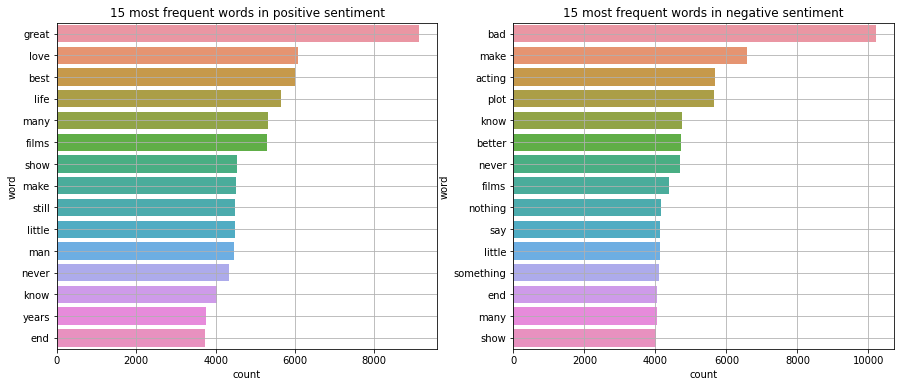

In [25]:
# count plots
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))
sns.barplot(x = "count", y = "word", data = pos_voc.head(15), ax = ax[0])
ax[0].set_title("15 most frequent words in positive sentiment")
ax[0].grid()
sns.barplot(x = "count", y = "word", data = neg_voc.head(15), ax = ax[1])
ax[1].set_title("15 most frequent words in negative sentiment")
ax[1].grid()
plt.show()

In the category with positive reviews it can seen that the most popular words are indeed the ones which can be connected with positivity (*great*, *love*, *best*) <br>
In case of negative the most obvious one is of course bad, which occurs almost 4000 times more often than the word *make* which is second most popular. <br>
It is worth to mention that the word *good* was excluded from the plots because it has occured in both categories and was the most popular one (in negative probably it was connected with word *not*) 

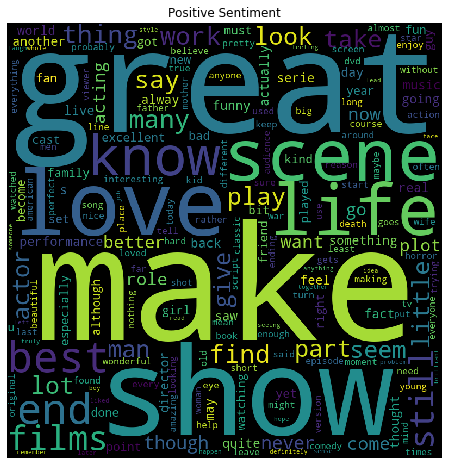

In [31]:
# word cloud for positive sentiment 
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS,              
                min_font_size = 10).generate(
    ' '.join(map(str,pd.DataFrame(np.c_[X_train,Y_train])[0].where(
        pd.DataFrame(np.c_[X_train,Y_train])[1] == 1).dropna()))) 

plt.imshow(wordcloud2)
plt.title('Positive Sentiment')
plt.axis('off')

plt.show() 

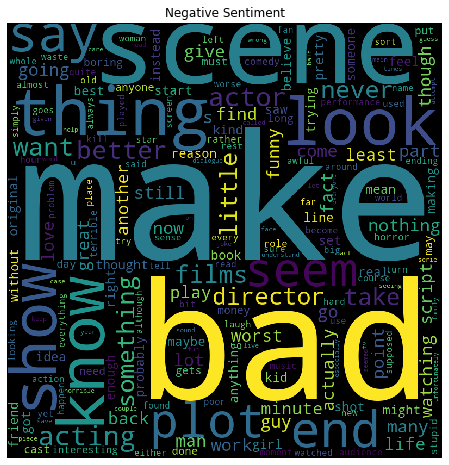

In [32]:
# word cloud for negative centiment
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(
    ' '.join(map(str,pd.DataFrame(np.c_[X_train,Y_train])[0].where(
        pd.DataFrame(np.c_[X_train,Y_train])[1] == 0).dropna())))

plt.imshow(wordcloud2)
plt.title('Negative Sentiment')
plt.axis('off')

plt.show() 

The word clouds are totally different, it can be observed that positive reviews often contains the words like great, love, scene, show, end, films, better, role, best, while negative reviews contains words like bad, something (probably with wrong), end, acting, funny, actor, never, simply, without, script, director, little. It may be concluded that good and bad feeling about movie is based on ending, scenario, acting, director etc. It is not so surprising, all these things adds up to a movie.

##### Modelling - embedding layer preparation

In [33]:
# get final training vocabulary
train_vocab = list(get_vocabulary(X_train).keys())

In [34]:
# build a token dictionary
# inicialization
word_index = {}
# embedding words
words_in_embedding = embeddings_index.keys()
i = 0
# loop through training vocabulary
for word in train_vocab:
    # covered word tokenization
    if word in words_in_embedding:
        word_index[word] = i
        i += 1
    # unknown token
    else:
        if not word_index.get("<OOV>"):
            word_index["<OOV>"] = i
            i += 1

In [2]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Function convert a vector of strings to its token representation with padding (batch training requirement).
    
    X -- sentences vector (strings)
    word_to_index - token dictionary
    max_len - fixed sentence length, shorter sentences are zero-padded 
    
    returns X_indices (padded and tokenized sentences - shape (number of observations, max sentence length))
    """
    
    # number of training examples
    m = X.shape[0]
    
    # inicialization (carry out padding)
    X_indices = np.zeros((m, max_len)) 
    
    # loop through training examples
    for i in range(m):                               
        
        # lowercasting just for safety, splitting sentence into words
        sentence_words = X[i].lower().split()
        
        # column iterator inicialization
        j = 0
        
        # loop through the words in obtained sentence
        for w in sentence_words:
            if w in word_to_index.keys():
                # tokenization saving (covered with embedding)
                X_indices[i, j] = word_to_index[w]
            else:
                # tokenization saving (unknown token)
                X_indices[i, j] = word_to_index["<OOV>"]
                
            # column iterator incrementation
            j = j + 1
            
    return X_indices

In [36]:
# train and dev set tokenization
X_train_ind = sentences_to_indices(X_train, word_index, maxLen)
X_dev_ind = sentences_to_indices(X_dev, word_index, maxLen)

In [37]:
# pre-trained embedding matrix preparation

# embedding dimension (GloVe 100 used)   
embedding_dim = 100

# embedding matrix inicialization (one zeros row is the Keras requirement)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# loop through tokens
for word, i in word_index.items():
    # embedding extraction
    embedding_vector = embeddings_index.get(word)
    # just for safety
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [38]:
# Keras Embedding layer building (not trainable)
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxLen,
                            trainable=False)

##### Convolutional Neural Network architecture

CNNs are very popular with NLP tasks. In this project CNN was used due to its effectivness/computational cost ratio.

In [39]:
sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x) 
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         6634300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           8204

In [47]:
# model training, 20 epochs, 256 batch size
history = model.fit(X_train_ind, Y_train, validation_data=(X_dev_ind, Y_dev),
                    epochs=20, batch_size=256)

Train on 34879 samples, validate on 9968 samples
Epoch 1/20
34879/34879 [==============================] - 151s 4ms/step - loss: 0.6698 - acc: 0.5969 - val_loss: 0.5298 - val_acc: 0.7478
Epoch 2/20
34879/34879 [==============================] - 151s 4ms/step - loss: 0.5061 - acc: 0.7582 - val_loss: 0.4511 - val_acc: 0.7811
Epoch 3/20
34879/34879 [==============================] - 151s 4ms/step - loss: 0.4183 - acc: 0.8097 - val_loss: 0.5369 - val_acc: 0.7329
Epoch 4/20
34879/34879 [==============================] - 151s 4ms/step - loss: 0.3688 - acc: 0.8356 - val_loss: 0.4382 - val_acc: 0.7894
Epoch 5/20
34879/34879 [==============================] - 151s 4ms/step - loss: 0.3360 - acc: 0.8560 - val_loss: 0.3282 - val_acc: 0.8599
Epoch 6/20
34879/34879 [==============================] - 151s 4ms/step - loss: 0.3006 - acc: 0.8712 - val_loss: 0.5240 - val_acc: 0.7786
Epoch 7/20
34879/34879 [==============================] - 151s 4ms/step - loss: 0.2688 - acc: 0.8848 - val_loss: 0.3734 - v

In [48]:
# model saving
#model.save("model_CNN_20_epochs.h5")

#### Plots with accuracy and loss during training

In [3]:
def plots(model, epoch, version="both"):
    plt.style.use("seaborn")
    plt.figure()
    plt.rcParams["font.family"] = "Courier New"

    if version == "both":
        plt.plot(np.arange(0, epoch), model.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epoch), model.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epoch), model.history["acc"], label="train_acc")
        plt.plot(np.arange(0, epoch), model.history["val_acc"], label="val_acc")
        plt.title("Loss and Accuracy during training")
        plt.ylabel("Loss/Accuracy")

    elif version == "loss":
        plt.plot(np.arange(0, epoch), model.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epoch), model.history["val_loss"], label="val_loss")
        plt.title("Loss during training")
        plt.ylabel("Loss")

    elif version == "acc":
        plt.plot(np.arange(0, epoch), model.history["acc"], label="train_acc")
        plt.plot(np.arange(0, epoch), model.history["val_acc"], label="val_acc")
        plt.title("Accuracy during training")
        plt.ylabel("Accuracy")

    plt.xlabel("Epoch #")
    plt.legend(loc="lower left")
    plt.show()

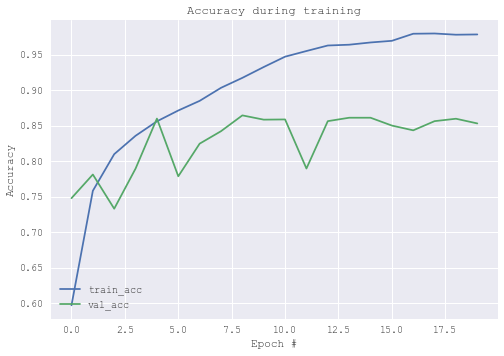

In [57]:
plots(history, epoch=20, version="acc")

Training accuracy was pretty while validation accuracy looks more random

In [ ]:
plots(his, epoch=20, version="loss")

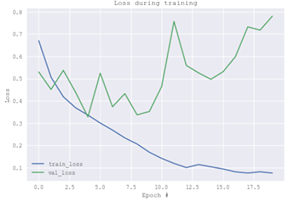

<br><br>
\*due to some problems the photo of the plot was attached instead of the plot itself

After the 8th epoch model start to overfit

##### Model's evaluation

In [51]:
X_test_ind = sentences_to_indices(X_test, word_index, maxLen)

model.evaluate(X_test_ind, Y_test)

4985/4985 [==============================] - 8s 2ms/step


[0.7262414247126374, 0.8603811264038086]

86% accuracy on the test set (approx. the same as on dev set), compared with the train set, the conclusion about overfitting may be upheld. Nevertheless final results are pretty decent

In [52]:
def results(real, pred):
    cm=confusion_matrix(real, pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))

    sns.set(font_scale=1) # for label size
    sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 11}) # font size

    plt.show()
    print(classification_report(real, pred))

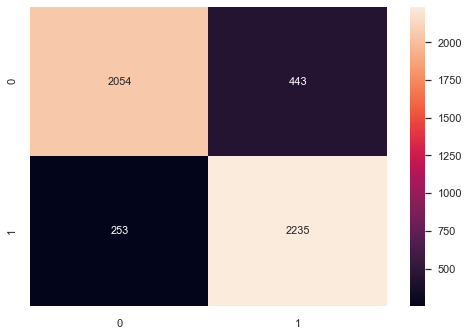

              precision    recall  f1-score   support

           0       0.89      0.82      0.86      2497
           1       0.83      0.90      0.87      2488

    accuracy                           0.86      4985
   macro avg       0.86      0.86      0.86      4985
weighted avg       0.86      0.86      0.86      4985



In [54]:
preds = model.predict(X_test_ind)
# assign score categories and logic
i = 0
preds_value = [ ] # empty series to hold our predicted values

while(i<len(preds)):
    if ((preds[i][0] > 0.5)):
        preds_value.append(1)
        i = i+1
    elif ((preds[i][0] <= 0.5)):
        preds_value.append(0)
        i = i+1
#print(preds_value)


results(Y_test, preds_value)

The model tends to predict positive sentiment as negative more often than negative sentiment as positive

##### Examples of misclassification

In [70]:
misclass = []
for i in range(len(preds)):
    if preds_value[i] != Y_test[i]:
        misclass.append(i)

#print(1-len(misclass)/len(preds))
def example(i, misclass):
    if i<len(misclass):
        print(f"True value: {Y_test[misclass[0]]}\nPredicted probability {preds[misclass[0]][0]}\nPredicted value: {preds_value[misclass[0]]}\nThe review:\n{X_test[misclass[0]]}")
    else:
        print("Try lower number")

example(3, misclass)

0.8004012036108326
True value: 1
Predicted probability 0.3731861710548401
Predicted value: 0
The review:
i would like to start by saying i can only hope that the makers of this movie and it is sister film the intruder directed by the great unheralded stylist auteur that is jopi burnama know in their hearts just how much pleasure they have brought to me and my friends in the sleepy north eastern town of jarrow from the opening pre credit sequence which manages to drag ever so slightly despite containing a man crashing through a window on a motorbike the pitiless destruction of a silence lab the introduction of one of the most simultaneously annoying and anaemic bad guys in movie history and costume design that jean paul gautier would find ott and garish make no mistake this is a truly unique experience early highlight an explosion get used to it plenty more where that came from followed by a close up of our chubby heroine and the most hilarious line reading of the word dad in living mem

### Vader

VADER is a VALENCE based sentiment analyzer <br>
Valence based approach taken into consideration the "intensity" of a word as opposed to only the polarity (+ve or -ve). For ex. "Great" is more treated as more +ve as opposed to "Good"<br>
Used scale:
- For 3 categories:
    - Neutral 0 < and > 0.7
    - Positive >=0.7
    - Negative <=0
- For 2 categories:
    - Positive >0
    - Negative <0

In [59]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maciej\AppData\Roaming\nltk_data...


In [60]:
df=pd.DataFrame()
df["review"]=X_test
df["sentiment"]=Y_test
df.sentiment = df.sentiment.apply(lambda x: "positive" if x == 1  else "negative")
df.head()

,review,sentiment
0,i would like to start by saying i can only hop...,positive
1,after visiting the kimbell museum in forth wor...,positive
2,i would buy that for a dollar i did buy this f...,positive
3,anyone who thinks this film has not been appre...,negative
4,perhaps i am out of date or just do not know w...,negative


In [61]:
# move to sentiment analysis
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)  #call the polarity analyzer
    print("{:-<40} {}".format(sentence, str(snt)))

In [62]:
# compound value scale = -1 to 1 (-ve to +ve)
print(df.sentiment[11])
print_sentiment_scores(df.review[11])

negative
while everyone does a decent job in this film i agree with the other comment it is too loose and scattered too much like a script less experiment with really talented actors as such it is not enough to hold your attention having said that there are a few really funny moments one involving dylan mcdermott and a flaming shot glass that i think anyone who is been that drunk would find as funny as i did the other is a split second with an inflatable dinosaur crispin glover does his usual nutty twitch fest guy and does it fine harry dean stanton does his usual nutty patriarch repo man anyone etc good cast not enough to keep it going just a few gems seconds long  {'neg': 0.036, 'neu': 0.816, 'pos': 0.149, 'compound': 0.9322}


In [63]:
%time # to calulate the time it takes the algorithm to compute a VADER score
start = time.time()

i=0 # counter
compval1 = [ ] # empty list to hold our computed 'compound' VADER scores

while (i<len(df)):
    k = analyser.polarity_scores(df.iloc[i]['review'])
    compval1.append(k['compound'])
    i = i+1
    if i%1000==0:
        stopPart = time.time()
        print("Time: {} seconds, number of obs: {}".format(round(stopPart-start, 2), i))
# convert sentiment values to numpy for easier usage
stop = time.time()
print("Total execution time: {} seconds, total number of obs: {}".format(round(stop-start, 2), i))
compval1 = np.array(compval1)
#len(compval1)

Wall time: 0 ns
Time: 2.57 seconds, number of obs: 1000
Time: 5.03 seconds, number of obs: 2000
Time: 7.51 seconds, number of obs: 3000
Time: 9.99 seconds, number of obs: 4000
Total execution time: 12.48 seconds, total number of obs: 4985


In [64]:
df['vader'] = compval1
df.head()

,review,sentiment,vader
0,i would like to start by saying i can only hop...,positive,-0.9407
1,after visiting the kimbell museum in forth wor...,positive,0.9922
2,i would buy that for a dollar i did buy this f...,positive,0.9872
3,anyone who thinks this film has not been appre...,negative,0.9178
4,perhaps i am out of date or just do not know w...,negative,0.7226


In [65]:
def labels(neutral):
    if neutral == True:
        # assign score categories and logic
        i = 0
        predicted_value = [ ] # empty series to hold our predicted values

        while(i<len(df)):
            if ((df.iloc[i]['vader'] >= 0.7)):
                predicted_value.append('positive')
                i = i+1
            elif ((df.iloc[i]['vader'] > 0) & (df.iloc[i]['vader'] < 0.7)):
                predicted_value.append('neutral')
                i = i+1
            elif ((df.iloc[i]['vader'] <= 0)):
                predicted_value.append('negative')
                i = i+1
    else: 
        # assign score categories and logic
        i = 0
        predicted_value = [ ] # empty series to hold our predicted values

        while(i<len(df)):
            if ((df.iloc[i]['vader'] > 0)):
                predicted_value.append('positive')
                i = i+1
            elif ((df.iloc[i]['vader'] <= 0)):
                predicted_value.append('negative')
                i = i+1
                
    return predicted_value

In [66]:
df['vader_prediction_N'] = labels(True)
df['vader_prediction'] = labels(False)
df.head()

,review,sentiment,vader,vader_prediction_N,vader_prediction
0,i would like to start by saying i can only hop...,positive,-0.9407,negative,negative
1,after visiting the kimbell museum in forth wor...,positive,0.9922,positive,positive
2,i would buy that for a dollar i did buy this f...,positive,0.9872,positive,positive
3,anyone who thinks this film has not been appre...,negative,0.9178,positive,positive
4,perhaps i am out of date or just do not know w...,negative,0.7226,positive,positive


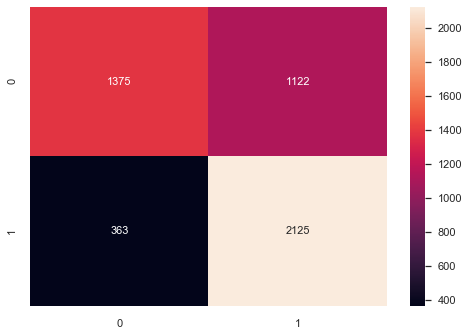

              precision    recall  f1-score   support

    negative       0.79      0.55      0.65      2497
    positive       0.65      0.85      0.74      2488

    accuracy                           0.70      4985
   macro avg       0.72      0.70      0.70      4985
weighted avg       0.72      0.70      0.70      4985



In [67]:
results(df.sentiment,df.vader_prediction)

As it can be seen the vader approach was used only on the test set to compare somehow results with the ones obtained by CNN. Accuracy in region of 0.7 is quite good, not great but it is better than it was assumed, but still it is significantly worse than CNN result

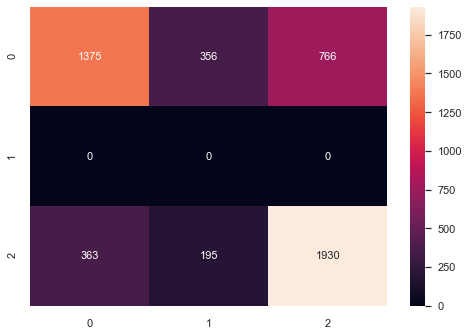

              precision    recall  f1-score   support

    negative       0.79      0.55      0.65      2497
     neutral       0.00      0.00      0.00         0
    positive       0.72      0.78      0.74      2488

    accuracy                           0.66      4985
   macro avg       0.50      0.44      0.46      4985
weighted avg       0.75      0.66      0.70      4985



C:\Users\maciej\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
results(df.sentiment,df.vader_prediction_N)

Negative reviews are more often taken as positive or neutral than positive as negative or neutral.

## Experiments

#### Maximum length of review

Max 250 words

In [4]:
start=time.time()
embedding_layer, maxLen, word_index, X_train_ind, Y_train, X_dev_ind, Y_dev, X_test, Y_test = own.dataset(250, 100, False, 0.7, 0.2, 0.1, 2021)


sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)  # global max pooling (zmieniany w zaleznosci od opcji dataset)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()
history = model.fit(X_train_ind, Y_train, validation_data=(X_dev_ind, Y_dev),
                    epochs=10, batch_size=256)
model.save("model_CNN_250_100_10_epochs.h5")
stop = time.time()
print("Total execution time: {} seconds".format(round(stop-start, 2)))

Max sentence length: 250
Embedding dimension: 100D
Stopwords used: False
Train part: 0.7
Dev part: 0.2
Test part: 0.1
Random state: 2021
Total execution time: 33.43 seconds
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 100)          4934200   
_________________________________________________________________
conv1d (Conv1D)              (None, 246, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 45, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (Max

In [5]:
X_test_ind = sentences_to_indices(X_test, word_index, maxLen)
model.evaluate(X_test_ind, Y_test)

111/111 [==============================] - 1s 12ms/step - loss: 0.3626 - acc: 0.8607


[0.3626479208469391, 0.8606557250022888]

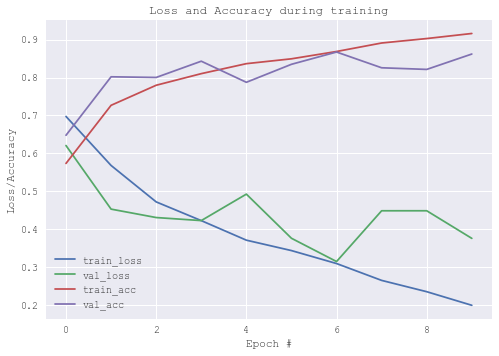

In [6]:
plots(history, epoch=10, version="both")

Max 500 words

In [7]:
start=time.time()
embedding_layer, maxLen, word_index, X_train_ind, Y_train, X_dev_ind, Y_dev, X_test, Y_test = own.dataset(500, 100, False, 0.7, 0.2, 0.1, 2021)

sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)  # global max pooling (zmieniany w zaleznosci od opcji dataset)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()
history = model.fit(X_train_ind, Y_train, validation_data=(X_dev_ind, Y_dev),
                    epochs=10, batch_size=256)

model.save("model_CNN_500_100_10_epochs.h5")
stop = time.time()
print("Total execution time: {} seconds".format(round(stop-start, 2)))

Max sentence length: 500
Embedding dimension: 100D
Stopwords used: False
Train part: 0.7
Dev part: 0.2
Test part: 0.1
Random state: 2021
Total execution time: 52.52 seconds
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          6057800   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 496, 128)          64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 99, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 95, 128)           82048     
_________________________________________________________________
max_pooling1d_4 (M

In [8]:
X_test_ind = sentences_to_indices(X_test, word_index, maxLen)
model.evaluate(X_test_ind, Y_test)

144/144 [==============================] - 6s 43ms/step - loss: 0.3542 - acc: 0.8708


[0.35415616631507874, 0.8707571625709534]

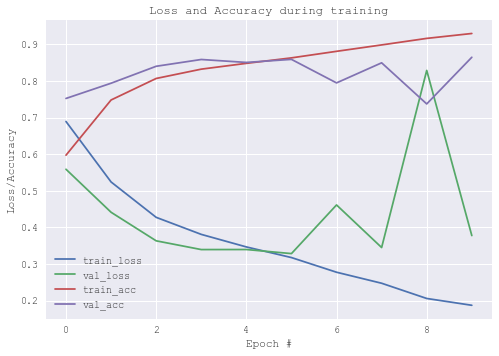

In [9]:
plots(history, epoch=10, version="both")

Max 1000 words

In [10]:
start=time.time()
embedding_layer, maxLen, word_index, X_train_ind, Y_train, X_dev_ind, Y_dev, X_test, Y_test = own.dataset(1000, 100, False, 0.7, 0.2, 0.1, 2021)

sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)  # global max pooling (zmieniany w zaleznosci od opcji dataset)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()
history = model.fit(X_train_ind, Y_train, validation_data=(X_dev_ind, Y_dev),
                    epochs=10, batch_size=256)

model.save("model_CNN_1000_100_10_epochs.h5")
stop = time.time()
print("Total execution time: {} seconds".format(round(stop-start, 2)))

Max sentence length: 1000
Embedding dimension: 100D
Stopwords used: False
Train part: 0.7
Dev part: 0.2
Test part: 0.1
Random state: 2021
Total execution time: 96.79 seconds
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         6634300   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_7 (

In [11]:
X_test_ind = sentences_to_indices(X_test, word_index, maxLen)
model.evaluate(X_test_ind, Y_test)

156/156 [==============================] - 10s 64ms/step - loss: 0.4103 - acc: 0.8439


[0.41032323241233826, 0.8439317941665649]

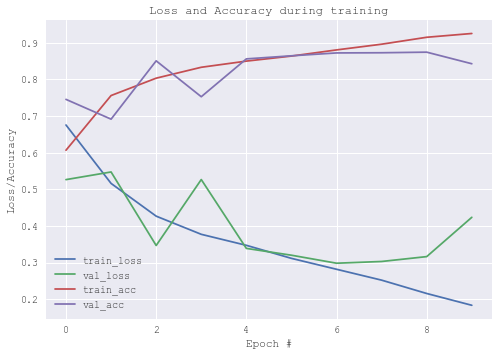

In [12]:
plots(history, epoch=10, version="both")

#### Embeddings

50D

In [14]:
start=time.time()
embedding_layer, maxLen, word_index, X_train_ind, Y_train, X_dev_ind, Y_dev, X_test, Y_test = own.dataset(500, 50, False, 0.7, 0.2, 0.1, 2021)

sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)  # global max pooling (zmieniany w zaleznosci od opcji dataset)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()
history = model.fit(X_train_ind, Y_train, validation_data=(X_dev_ind, Y_dev),
                    epochs=10, batch_size=256)

model.save("model_CNN_500_50_10_epochs.h5")
stop = time.time()
print("Total execution time: {} seconds".format(round(stop-start, 2)))

Max sentence length: 500
Embedding dimension: 50D
Stopwords used: False
Train part: 0.7
Dev part: 0.2
Test part: 0.1
Random state: 2021
Total execution time: 58.3 seconds
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 50)           3028900   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 496, 128)          32128     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 99, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 95, 128)           82048     
_________________________________________________________________
max_pooling1d_10 (Ma

In [15]:
X_test_ind = sentences_to_indices(X_test, word_index, maxLen)
model.evaluate(X_test_ind, Y_test)

144/144 [==============================] - 1s 10ms/step - loss: 0.5072 - acc: 0.7533


[0.5072380900382996, 0.7532637119293213]

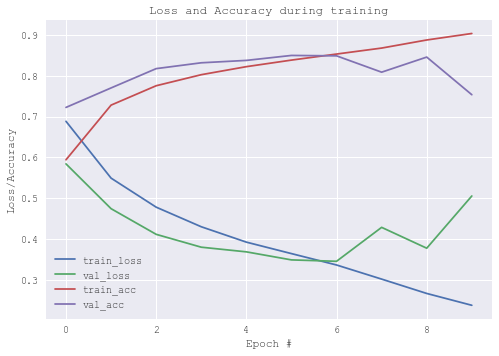

In [16]:
plots(history, epoch=10, version="both")

300D

In [17]:
start=time.time()
embedding_layer, maxLen, word_index, X_train_ind, Y_train, X_dev_ind, Y_dev, X_test, Y_test = own.dataset(500, 300, False, 0.7, 0.2, 0.1, 2021)

sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)  # global max pooling (zmieniany w zaleznosci od opcji dataset)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()
history = model.fit(X_train_ind, Y_train, validation_data=(X_dev_ind, Y_dev),
                    epochs=10, batch_size=256)

model.save("model_CNN_500_300_10_epochs.h5")
stop = time.time()
print("Total execution time: {} seconds".format(round(stop-start, 2)))

Max sentence length: 500
Embedding dimension: 300D
Stopwords used: False
Train part: 0.7
Dev part: 0.2
Test part: 0.1
Random state: 2021
Total execution time: 46.22 seconds
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 300)          18173400  
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 496, 128)          192128    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 99, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 95, 128)           82048     
_________________________________________________________________
max_pooling1d_13 (

In [18]:
X_test_ind = sentences_to_indices(X_test, word_index, maxLen)
model.evaluate(X_test_ind, Y_test)

144/144 [==============================] - 6s 41ms/step - loss: 0.4398 - acc: 0.8903


[0.4398419260978699, 0.8903394341468811]

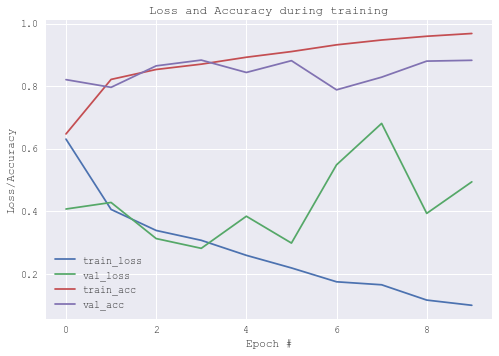

In [19]:
plots(history, epoch=10, version="both")

#### Stopwords

Stopwords excluded

In [21]:
#stopword
start=time.time()
embedding_layer, maxLen, word_index, X_train_ind, Y_train, X_dev_ind, Y_dev, X_test, Y_test = own.dataset(500, 100, True, 0.7, 0.2, 0.1, 2021)

sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)  # global max pooling (zmieniany w zaleznosci od opcji dataset)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()
history = model.fit(X_train_ind, Y_train, validation_data=(X_dev_ind, Y_dev),
                    epochs=10, batch_size=256)

model.save("model_CNN_500_100_10_epochs.h5")
stop = time.time()
print("Total execution time: {} seconds".format(round(stop-start, 2)))

Max sentence length: 500
Embedding dimension: 100D
Stopwords used: True
Train part: 0.7
Dev part: 0.2
Test part: 0.1
Random state: 2021
Total execution time: 31.17 seconds
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 500, 100)          6043600   
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 496, 128)          64128     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 99, 128)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 95, 128)           82048     
_________________________________________________________________
max_pooling1d_16 (M

In [22]:
X_test_ind = sentences_to_indices(X_test, word_index, maxLen)
model.evaluate(X_test_ind, Y_test)

144/144 [==============================] - 2s 15ms/step - loss: 0.5107 - acc: 0.7842


[0.5106518864631653, 0.7841601371765137]

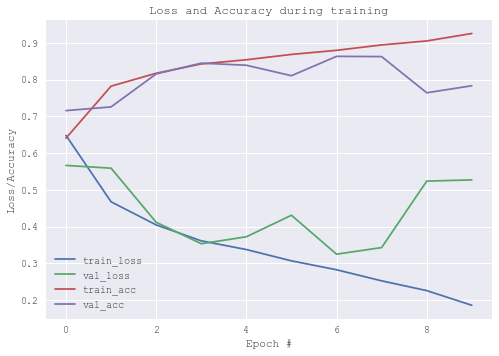

In [23]:
plots(history, epoch=10, version="both")

##### Results

|           	| len 250 <br> emb 100 <br> sw false <br> 	| len 500  <br> emb 100  <br> sw false  <br> 	| len 1000  <br> emb 100  <br> sw false  <br> 	| len 500  <br> emb 50  <br> sw false  <br> 	| len 500  <br> emb 300  <br> sw false  <br> 	| len 500  <br> emb 100  <br> sw true  <br> 	|
|-----------	|-----------------------------------------	|--------------------------------------------	|---------------------------------------------	|-------------------------------------------	|--------------------------------------------	|-------------------------------------------	|
| Accuracy  	| 0.8584                                  	| 0.8705                                     	| 0.7771                                      	| 0.8551                                    	| 0.8795                                     	| 0.8436                                    	|
|  Time (s) 	| 205                                     	| 500                                        	| 1045                                        	| 397                                       	| 1035                                       	| 497                                       	|

<br><br>
\*Values of the metrics are different from the one which can be seen in the training process above, because they came from previous training (due to occured computational issues)

In case of the maximum length of the review the best option seems to be about 500 words, it gives pretty decent result, and the computation time is not so long, we can see some anomaly with 1000 words (the result is really low). <br>
In case of embedding dimension, 50 is definietely to low, obviously 300 is better than 100, but it need twice the time to train, well probably it should be used when someone has enough computional power. <br>
It can also be seen that exlusion of the stop words make results worse (about 2.5 percetage points), so it definitely shouldn't be removed.

##### Recurrent neural network

In [47]:
embedding_layer, maxLen, word_index, X_train_ind, Y_train, X_dev_ind, Y_dev, X_test, Y_test = own.dataset(500, 100, False, 0.7, 0.2, 0.1, 2021)

sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
y = Bidirectional(LSTM(128, return_sequences=True))(embedded_sequences)
y = LSTM(64)(y)
y = Dropout(0.4)(y)
preds = Dense(1, activation='sigmoid')(y)

modelRNN = Model(sequence_input, preds)
modelRNN.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

modelRNN.summary()

Max sentence length: 500
Embedding dimension: 100D
Stopwords used: False
Train part: 0.7
Dev part: 0.2
Test part: 0.1
Random state: 2021
Total execution time: 36.63 seconds
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 100)          6057800   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 256)          234496    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)   

In [49]:
historyRNN = modelRNN.fit(X_train_ind, Y_train, validation_data=(X_dev_ind, Y_dev),
                          epochs=4, batch_size=256)

Train on 32188 samples, validate on 9232 samples
Epoch 1/4
32188/32188 [==============================] - 5701s 177ms/step - loss: 0.6989 - acc: 0.4963 - val_loss: 0.6987 - val_acc: 0.5091
Epoch 2/4
32188/32188 [==============================] - 7763s 241ms/step - loss: 0.6943 - acc: 0.5000 - val_loss: 0.6945 - val_acc: 0.4909
Epoch 3/4
32188/32188 [==============================] - 8502s 264ms/step - loss: 0.6933 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.5090
Epoch 4/4
  256/32188 [..............................] - ETA: 2:16:35 - loss: 0.6920 - acc: 0.5547

KeyboardInterrupt: 

There is no hope for the proposed RNN, the accuracy is at the random estimator level and the training time is positively correlated with the number of epoch, a longer training does not make sense.

### Conclusions

After performed analysis it may be conluded that positive and negative movie reviews are totally different. The differences could be seen especially on the count and word cloud words after detailed stop words removal. <br>
In tasks like this one the big challange is to spot and remove/substitute contraction of words or the ones that are unneccasery. <br>
The above mentioned problem was especially important while using pretrained word embeddings in the neural network. <br>
Proposed neural network architecture solved the task pretty well (approx. 98%, 85% and 86% accuracy on the training dev and test set, respectively). It may be concluded that the training process should be little bit shorter or some additional regularization should be used to deal with overfitting problem. <br>
Compared to RNN, CNNs were much faster and gave much better results.<br>
Performed Vader analysis gave surprisingly decent results (approx. 70% accuracy score, even better than the RNN).<br>
After the experiment process it may be concluded that training process time is almost lineary positively correlated with the maximum length of the review, which should be considered while choosing the optimal length limit. It is also appropiate to conlcude that the 100 dimnesional embeddings are good enough for the job, because the results weren't much worse than using 300 dimensional ones, but the model needs twice the time to train. Exclusion of the stop words from the reviews made the results worse.<br>